- Import necessary libraries

In [8]:
import os
import pandas as pd
import nltk
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, TextClassificationPipeline
import nltk
from nltk.corpus import stopwords
import string
import langid
from datasets import Dataset
import kagglehub
import warnings
warnings.filterwarnings("ignore")

# Create data and model folders
os.makedirs("data", exist_ok=True)
os.makedirs("model", exist_ok=True)

### 1) Data Reading and Cleaning

- Dataset path -> https://www.kaggle.com/datasets/davutb/metacritic-games
- Metacritic Scraper GitHub repository -> https://github.com/davutbayik/metacritic-backend-scraper

In [ ]:
# Download the dataset from kaggle using kagglehub
path = kagglehub.dataset_download("davutb/metacritic-games")

print("Path to dataset files:", path)

df_path = os.path.join(path, "games_reviews.csv")
games_reviews = pd.read_csv(df_path)

games_reviews.sample(5)

,id,title,quote,score,date,platform,author,publicationName,review_type
121898,1300462907,The Last of Us Part II,The best game I have ever played. To be honest...,100.0,2020-07-03,PlayStation 4,Sreyaskandhan,NaN,user
1476957,1300494391,Panzer Dragoon,Phenomenal package. Beautiful presentation thr...,100.0,2020-10-02,PC,Dingo__,NaN,user
1493024,1300246095,Goat Simulator,"Great fun, especially with friends, Goat Simul...",80.0,2015-08-20,PlayStation 4,NaN,PlayStation Universe,critic
890,1300001290,The Legend of Zelda: Ocarina of Time,What can be said about this game that has not ...,100.0,2015-08-10,Nintendo 64,harhas97,NaN,user
64401,1300502074,The Legend of Zelda: Tears of the Kingdom,"Tears of the Kingdom 10/10, Metacritic 1/10. I...",100.0,2023-05-20,Nintendo Switch,FuriousGeorge,NaN,user


In [ ]:
# Check null value numbers
# We can drop reviews with no review text or review score if NaN number is low.
games_reviews.isna().sum()

id                       0
title                    0
quote                  146
score                 7196
date                204108
platform                 0
author              524362
publicationName    1131692
review_type              0
dtype: int64

In [ ]:
# Delete reviews without text or score
games_reviews.drop(games_reviews[pd.isna(games_reviews["quote"]) | pd.isna(games_reviews["score"])].index, axis=0, inplace=True)

In [ ]:
# Detect each reviews language using langid library and select English reviews
games_reviews.loc[:, 'language'] = games_reviews.loc[:, 'quote'].apply(lambda x: langid.classify(x)[0])
games_reviews = games_reviews.query("language == 'en'")

In [ ]:
# Label sentiments from scores for training the dataset
def get_sentiment(score):
    try:
        score = float(score)
        if score >= 70:
            return 2  # Positive
        elif score <= 40:
            return 0  # Negative
        else:
            return 1  # Neutral
    except:
        return 1

games_reviews.loc[:, 'labels'] = games_reviews.loc[:, 'score'].apply(get_sentiment)

In [ ]:
# Preprocessing using nltk library
# Removing stopwords, punctuation, whitespace characters and converting lowercase

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    tokens = nltk.word_tokenize(str(text).lower().strip())
    tokens = [t for t in tokens if t not in string.punctuation and t not in stop_words]
    return " ".join(tokens)

games_reviews['quote_cleaned'] = games_reviews['quote'].apply(clean_text)

In [5]:
# Delete null reviews if any occured after cleaning the dataset 
games_reviews.drop(games_reviews[pd.isna(games_reviews["quote_cleaned"])].index, axis=0, inplace=True)

### 2) Fine Tuning the Dataset

In [7]:
# Train-test split
train_df, test_df = train_test_split(games_reviews[['quote_cleaned', 'labels']], test_size=0.25, shuffle=True, random_state=33)

- Use a pre-trained BERT model. In terms of efficiency, I will use smaller BERT-medium model rather than base models.
	- Even smaller models like BERT-small or BERT-tiny models can be used and performed well.
- Source of the BERT-medium model --> https://huggingface.co/prajjwal1/bert-medium

In [ ]:
# Tokenize with a pre-trained BERT model

#tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny', model_max_length=512)
#tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-small', model_max_length=512)
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-medium', model_max_length=512)

In [9]:
# Create train and test datasets using huggingface's Dataset module
train_dataset = Dataset.from_pandas(train_df.rename(columns={'quote_cleaned': 'text'}))
test_dataset = Dataset.from_pandas(test_df.rename(columns={'quote_cleaned': 'text'}))

In [10]:
# Tokenize the train and test datasets
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True)

train_df = train_dataset.map(tokenize_function, batched=True)
test_df = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1114912 [00:00<?, ? examples/s]

Map:   0%|          | 0/371638 [00:00<?, ? examples/s]

In [ ]:
# Save tokenized datasets
train_df.save_to_disk("data/train_dataset_tokenized")
test_df.save_to_disk("data/test_dataset_tokenized")

Saving the dataset (0/2 shards):   0%|          | 0/1114912 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/371638 [00:00<?, ? examples/s]

- GPU usage for fine-tuning a pre-trained BERT model is highly recommended otherwise the training would be extremely slow

In [ ]:
# Load a pre-trained BERT model

#model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=3)
#model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-small', num_labels=3)
model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-medium', num_labels=3)

# Use GPU to train the model if you have a GPU
model.to(torch.device('cuda'))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-7): 8 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, e

- Fine-Tune the model by training it with our data

In [ ]:
# Training setup

training_args = TrainingArguments(
    output_dir="./model_parameters",
    logging_dir=None,  # This will stop logs from being saved to a file
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=1000,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_df,
    eval_dataset=test_df,
    tokenizer=tokenizer,
    data_collator=data_collator
    )

# Train the model
trainer.train()

  0%|          | 0/209046 [00:00<?, ?it/s]

{'loss': 0.365, 'grad_norm': 17.553478240966797, 'learning_rate': 1.9904327277249983e-05, 'epoch': 0.01}
{'loss': 0.5117, 'grad_norm': 10.742671966552734, 'learning_rate': 1.9808654554499968e-05, 'epoch': 0.03}
{'loss': 0.4983, 'grad_norm': 9.66846752166748, 'learning_rate': 1.9712981831749953e-05, 'epoch': 0.04}
{'loss': 0.4773, 'grad_norm': 5.602819442749023, 'learning_rate': 1.9617309108999934e-05, 'epoch': 0.06}
{'loss': 0.4794, 'grad_norm': 5.983526229858398, 'learning_rate': 1.952163638624992e-05, 'epoch': 0.07}
{'loss': 0.4745, 'grad_norm': 5.697776794433594, 'learning_rate': 1.94259636634999e-05, 'epoch': 0.09}
{'loss': 0.4549, 'grad_norm': 8.533885955810547, 'learning_rate': 1.9330290940749885e-05, 'epoch': 0.1}
{'loss': 0.4599, 'grad_norm': 4.551764011383057, 'learning_rate': 1.9234618217999866e-05, 'epoch': 0.11}
{'loss': 0.4425, 'grad_norm': 6.059841156005859, 'learning_rate': 1.913894549524985e-05, 'epoch': 0.13}
{'loss': 0.4543, 'grad_norm': 13.799579620361328, 'learning_

  0%|          | 0/23228 [00:00<?, ?it/s]

{'eval_loss': 0.38431647419929504, 'eval_runtime': 653.0775, 'eval_samples_per_second': 569.057, 'eval_steps_per_second': 35.567, 'epoch': 1.0}
{'loss': 0.3837, 'grad_norm': 5.588892459869385, 'learning_rate': 1.330290940749883e-05, 'epoch': 1.0}
{'loss': 0.3682, 'grad_norm': 4.151134490966797, 'learning_rate': 1.3207236684748812e-05, 'epoch': 1.02}
{'loss': 0.361, 'grad_norm': 1.975178599357605, 'learning_rate': 1.3111563961998797e-05, 'epoch': 1.03}
{'loss': 0.3647, 'grad_norm': 5.2469868659973145, 'learning_rate': 1.301589123924878e-05, 'epoch': 1.05}
{'loss': 0.3685, 'grad_norm': 3.095139980316162, 'learning_rate': 1.2920218516498761e-05, 'epoch': 1.06}
{'loss': 0.363, 'grad_norm': 3.0231447219848633, 'learning_rate': 1.2824545793748746e-05, 'epoch': 1.08}
{'loss': 0.3591, 'grad_norm': 7.342517375946045, 'learning_rate': 1.2728873070998729e-05, 'epoch': 1.09}
{'loss': 0.3668, 'grad_norm': 6.121874809265137, 'learning_rate': 1.263320034824871e-05, 'epoch': 1.11}
{'loss': 0.3696, 'gr

  0%|          | 0/23228 [00:00<?, ?it/s]

{'eval_loss': 0.3735402524471283, 'eval_runtime': 640.5883, 'eval_samples_per_second': 580.151, 'eval_steps_per_second': 36.26, 'epoch': 2.0}
{'loss': 0.3317, 'grad_norm': 11.275650024414062, 'learning_rate': 6.605818814997657e-06, 'epoch': 2.01}
{'loss': 0.3168, 'grad_norm': 6.173707485198975, 'learning_rate': 6.51014609224764e-06, 'epoch': 2.02}
{'loss': 0.3143, 'grad_norm': 15.49158000946045, 'learning_rate': 6.414473369497624e-06, 'epoch': 2.04}
{'loss': 0.3181, 'grad_norm': 2.6150474548339844, 'learning_rate': 6.318800646747606e-06, 'epoch': 2.05}
{'loss': 0.3213, 'grad_norm': 10.56812572479248, 'learning_rate': 6.223127923997589e-06, 'epoch': 2.07}
{'loss': 0.3079, 'grad_norm': 8.948488235473633, 'learning_rate': 6.127455201247573e-06, 'epoch': 2.08}
{'loss': 0.3138, 'grad_norm': 9.017119407653809, 'learning_rate': 6.031782478497556e-06, 'epoch': 2.1}
{'loss': 0.3236, 'grad_norm': 7.776458263397217, 'learning_rate': 5.9361097557475385e-06, 'epoch': 2.11}
{'loss': 0.3201, 'grad_no

  0%|          | 0/23228 [00:00<?, ?it/s]

{'eval_loss': 0.386043518781662, 'eval_runtime': 626.2252, 'eval_samples_per_second': 593.457, 'eval_steps_per_second': 37.092, 'epoch': 3.0}
{'train_runtime': 18808.6281, 'train_samples_per_second': 177.83, 'train_steps_per_second': 11.114, 'train_loss': 0.3632863544655242, 'epoch': 3.0}


TrainOutput(global_step=209046, training_loss=0.3632863544655242, metrics={'train_runtime': 18808.6281, 'train_samples_per_second': 177.83, 'train_steps_per_second': 11.114, 'train_loss': 0.3632863544655242, 'epoch': 3.0})

In [ ]:
# Save the tuned model and the tokenizer

save_directory = "tuned_model/metacritic_games_bert" # Model directory for saving

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('tuned_model/metacritic_games_bert\\tokenizer_config.json',
 'tuned_model/metacritic_games_bert\\special_tokens_map.json',
 'tuned_model/metacritic_games_bert\\vocab.txt',
 'tuned_model/metacritic_games_bert\\added_tokens.json')

### 3) Get Sentiments and Sentiment Scores

In [9]:
# Load the tuned model

model = BertForSequenceClassification.from_pretrained('model/metacritic_games_bert')
model.to('cuda') # Use GPU
tokenizer = BertTokenizer.from_pretrained('model/metacritic_games_bert', model_max_length=512)

prediction_pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, max_length=512, truncation=True, top_k=1, device="cuda")

In [3]:
from datasets import load_dataset
from evaluate import evaluator
from transformers import AutoModelForSequenceClassification, pipeline

data = load_dataset("imdb", split="test").shuffle(seed=42).select(range(1000))
task_evaluator = evaluator("text-classification")

In [17]:
model = BertForSequenceClassification.from_pretrained('model/metacritic_games_bert')
model.to('cuda') # Use GPU
tokenizer = BertTokenizer.from_pretrained('model/metacritic_games_bert', model_max_length=512)

prediction_pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, max_length=512, truncation=True, top_k=1, device="cuda")

In [32]:
from datasets import load_from_disk
import evaluate
from evaluate import evaluator
from transformers import AutoModelForSequenceClassification, pipeline

train_df = load_from_disk("data/train_dataset_tokenized")
test_df = load_from_disk("data/test_dataset_tokenized")

task_evaluator = evaluator("text-classification")

model = BertForSequenceClassification.from_pretrained('model/metacritic_games_bert')
model.to('cuda') # Use GPU
tokenizer = BertTokenizer.from_pretrained('model/metacritic_games_bert', model_max_length=512)

prediction_pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, max_length=512, truncation=True, top_k=1, device="cuda")

eval_results = task_evaluator.compute(
    model_or_pipeline=model,
    tokenizer=tokenizer,
    data=test_df,
    input_column="text",
    label_column="labels",
    label_mapping={"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2},
    metric=evaluate.combine(['accuracy', 'f1']),
)
print(eval_results)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [33]:
df = pd.read_csv("data/games_reviews_english_sentimented.csv")

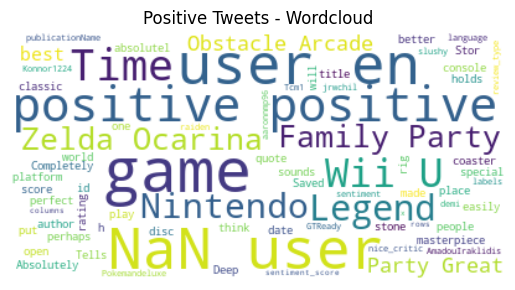

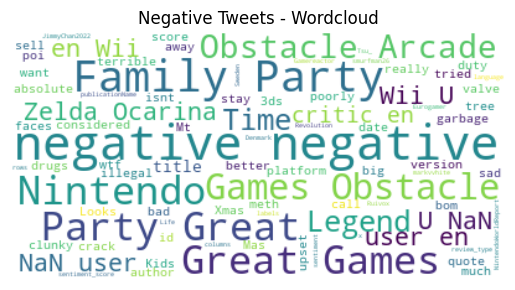

In [38]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

# Wordcloud with positive tweets
positive_tweets = df.query("sentiment == 'positive'")
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
 
# Wordcloud with negative tweets
negative_tweets = df.query("sentiment == 'negative'")
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\davutbayik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


FileNotFoundError: [Errno 2] No such file or directory: 'visualizations/sentiment_wordclouds.png'

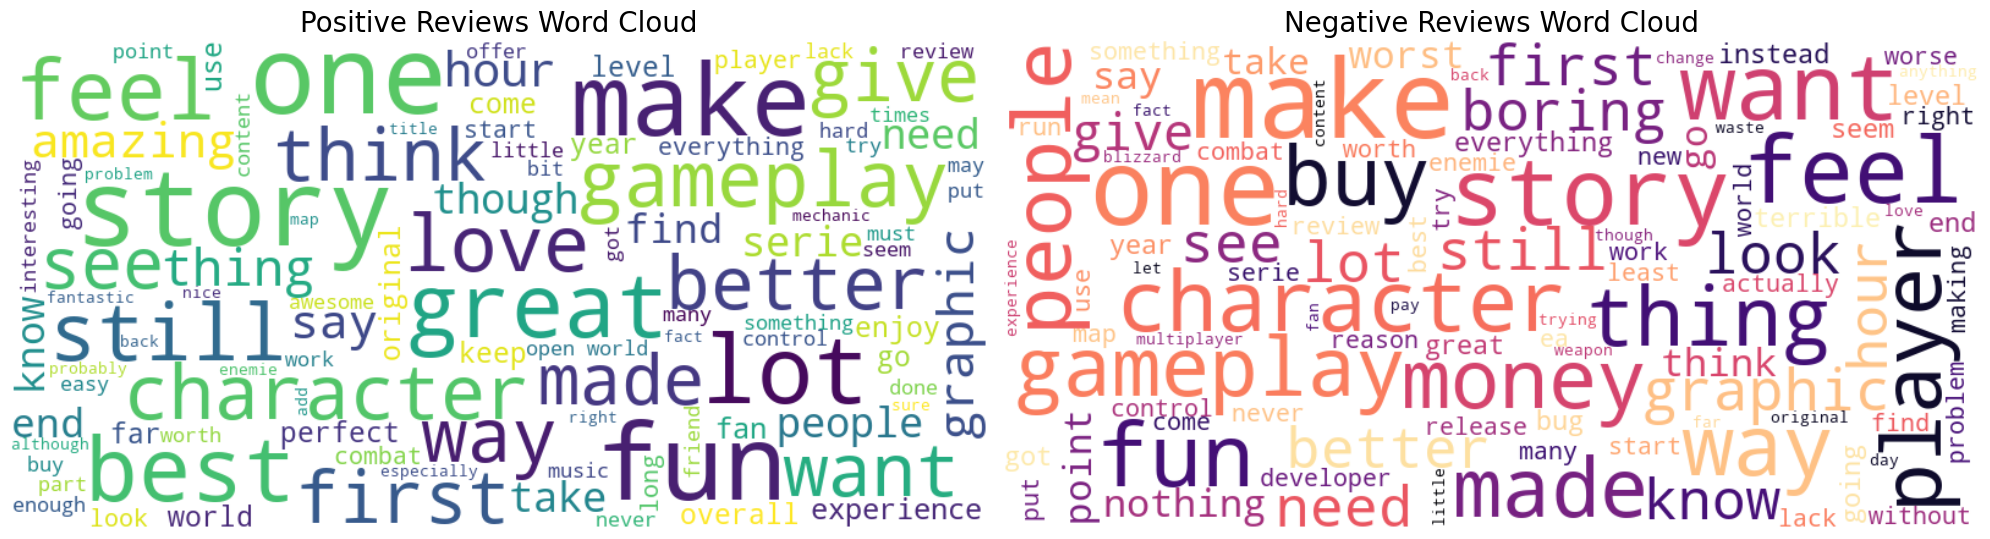

In [ ]:
# Model labels
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}

In [ ]:
# Change label names to sentiments according to label settings earlier
model.config.id2label[0] = "negative"
model.config.id2label[1] = "neutral"
model.config.id2label[2] = "positive"

model.config.id2label

{0: 'negative', 1: 'neutral', 2: 'positive'}

In [ ]:
# Function for predicting the input sizes longer than 512 

def predict_long_text_gpu(text, tokenizer, model, max_length=512, stride=256, device="cuda"):
    model.to(device) # Use GPU
    model.eval()

    # Tokenize the full text first (no truncation)
    tokens = tokenizer.encode(text, add_special_tokens=True)

    # Manually split into overlapping chunks
    chunks = []
    start = 0
    while start < len(tokens):
        end = min(start + max_length, len(tokens))
        chunk = tokens[start:end]
        chunks.append(chunk)
        if end == len(tokens):
            break
        start += stride

    logits_list = []

    for chunk in chunks:
        # Pad chunk to max_length
        padding_length = max_length - len(chunk)
        input_ids = chunk + [tokenizer.pad_token_id] * padding_length
        attention_mask = [1] * len(chunk) + [0] * padding_length

        # Send to GPU
        input_tensor = {
            "input_ids": torch.tensor([input_ids], device=device),
            "attention_mask": torch.tensor([attention_mask], device=device)
        }

        with torch.no_grad():
            outputs = model(**input_tensor)
            logits = outputs.logits
            logits_list.append(logits)

    # Aggregate logits (mean pooling across chunks)
    final_logits = torch.stack(logits_list).mean(dim=0)
    prediction = torch.nn.functional.softmax(final_logits, dim=-1)

    return model.config.id2label[prediction.argmax().item()], max(prediction[0]).item()

In [69]:
# Sentiment prediction for input sizes higher than 512

games_reviews["sentiment"] = None
games_reviews["sentiment_score"] = None

for ind in games_reviews[games_reviews["quote_cleaned"].str.len() > 512].index:
    
    sentiment, score = predict_long_text_gpu(games_reviews.loc[ind, "quote_cleaned"], tokenizer, model)
    games_reviews.loc[ind, "sentiment"] = sentiment
    games_reviews.loc[ind, "sentiment_score"] = score

In [70]:
# Sentiment prediction for input sizes lower than 512

sentiment_results_512 = prediction_pipeline(list(games_reviews[games_reviews["quote_cleaned"].str.len() <= 512].loc[:, "quote_cleaned"]))
for i, ind in enumerate(games_reviews[games_reviews["quote_cleaned"].str.len() <= 512].index):

	games_reviews.loc[ind, "sentiment"] = sentiment_results_512[i][0]["label"]
	games_reviews.loc[ind, "sentiment_score"] = sentiment_results_512[i][0]["score"]

In [3]:
games_reviews.sample(5)

,id,title,quote,score,date,platform,author,publicationName,review_type,language,labels,sentiment,sentiment_score
337182,1300518492,Gran Turismo 7,Always online DRM. Microtransactions hidden du...,0.0,2022-03-21,PlayStation 5,MrTexaspete,NaN,user,en,0,negative,0.993914
1402886,1300145620,Dead Island: Riptide,If you’ve got several friends who loved the fi...,57.0,2013-04-23,PlayStation 3,NaN,PSX Extreme,critic,en,1,neutral,0.753367
1466508,1300599373,Jujutsu Kaisen: Cursed Clash,Insult to JJK fans. Never let them cook again....,30.0,2024-02-12,PlayStation 5,CrowzerVidia,NaN,user,en,0,negative,0.994562
1290062,1300412396,F1 2015,"In my experience, setting the game to Pro and ...",72.0,2015-08-13,PlayStation 4,NaN,COGconnected,critic,en,2,positive,0.641356
167928,1300030490,God of War: Chains of Olympus,"Overall, you'd be a damn idiot if you didn't p...",100.0,NaN,PSP,NaN,Modojo,critic,en,2,positive,0.751129


### 4) Save the Sentimented Dataset

In [ ]:
# Drop cleaned text and save the sentimented dataset

games_reviews.drop(columns=["quote_cleaned"], inplace=True)
games_reviews.to_csv("data/games_reviews_english_sentimented.csv", index=False)